**Final Project for Introduction to Machine Learning: Supervised Learning**

***Sleep Disorder EDA and Supervised Learning Predictive Modeling***

**Problem Description**

In this project, the focus is to explore how various health, lifestyle, and demographic factors relate to the presence of sleep disorders. I have compiled two different datasets—“Sleep_health_and_lifestyle_dataset.csv” and “Health_Sleep_Statistics.csv”—which provide information on individuals’ age, gender, physical activity level, dietary habits, stress level, sleep duration, sleep quality, BMI category, blood pressure, heart rate, and other relevant attributes. The core question is whether these variables can help explain or even predict a person’s likelihood of having a sleep disorder.

Sleep is critical for both physical and mental health. Sleep disorders can have profound effects on daily functioning, productivity, and overall well-being. By examining the relationship between a broad set of health/lifestyle indicators and the presence of a sleep disorder, the aim is to:

1. **Identify which factors correlate most strongly with sleep disorders**
2. **Build a predictive model** using supervised machine learning that accurately classifies individuals as having a sleep disorder or not, based on their health/lifestyle data.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Imported csv files from Kaggle
df1 = pd.read_csv('/Sleep_health_and_lifestyle_dataset.csv')
df2 = pd.read_csv('/Health_Sleep_Statistics.csv')

In [ ]:
# Inspecting First Data Set
df1.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [ ]:
# Inspecting Second Data Set
df2.head()

,User ID,Age,Gender,Sleep Quality,Bedtime,Wake-up Time,Daily Steps,Calories Burned,Physical Activity Level,Dietary Habits,Sleep Disorders,Medication Usage
0,1,25,f,8,23:00,06:30,8000,2500,medium,healthy,no,no
1,2,34,m,7,00:30,07:00,5000,2200,low,unhealthy,yes,yes
2,3,29,f,9,22:45,06:45,9000,2700,high,healthy,no,no
3,4,41,m,5,01:00,06:30,4000,2100,low,unhealthy,yes,no
4,5,22,f,8,23:30,07:00,10000,2800,high,medium,no,no


In [ ]:
# Data Cleaning and Concatting

# drop individual IDs concating the data
df1_cleaned = df1.drop(columns=['Person ID'])
df2_cleaned = df2.drop(columns=['User ID'])

df2_cleaned = df2_cleaned.rename(columns={
    "Sleep Quality": "Quality of Sleep",
    "Sleep Disorders": "Sleep Disorder"
})

# drop rows where individuals take medication for their sleep disorder (will skew analyses)
df2_cleaned = df2_cleaned[df2_cleaned['Medication Usage'] != 'Yes']

# make physical activity levels consistent with both datasets
physical_activity_quantiles = df1['Physical Activity Level'].quantile([0.33, 0.66])

def categorize_physical_activity(level):
    if level <= physical_activity_quantiles[0.33]:
        return 'low'
    elif level <= physical_activity_quantiles[0.66]:
        return 'medium'
    else:
        return 'high'
df1_cleaned['Physical Activity Level'] = df1['Physical Activity Level'].apply(categorize_physical_activity)

# make gender consistent with both datasets
df2_cleaned['Gender'] = np.where(df2_cleaned['Gender'] == 'f', 'Female', 'Male')

# make sleep disorder consistent with both datasets
df1_cleaned['Sleep Disorder'] = df1_cleaned['Sleep Disorder'].apply(lambda x: 'no' if pd.isnull(x) else 'yes')

# Clean BMI column
df1_cleaned['BMI Category'] = df1_cleaned['BMI Category'].replace('Normal Weight', 'Normal')

# Make Blood Pressure Categorical
def parse_systolic(bp_str):
    if pd.isnull(bp_str):
        return np.nan

    parts = bp_str.split('/')
    if len(parts) != 2:
        return np.nan
    systolic = int(parts[0])
    return systolic

def categorize_blood_pressure(systolic):
    if pd.isnull(systolic):
        return np.nan

    if systolic <= 90:
        return 'low'
    elif systolic <= 130:
        return 'normal'
    else:
        return 'high'

df1_cleaned['Systolic'] = df1_cleaned['Blood Pressure'].apply(parse_systolic)
df1_cleaned['Blood Pressure'] = df1_cleaned['Systolic'].apply(categorize_blood_pressure)

# make sleep duration consistent with both datasets
df2_cleaned['Bedtime'] = pd.to_datetime(df2_cleaned['Bedtime'], format='%H:%M')
df2_cleaned['Wake-up Time'] = pd.to_datetime(df2_cleaned['Wake-up Time'], format='%H:%M')
df2_cleaned['Sleep Duration'] = (df2_cleaned['Wake-up Time'] - df2_cleaned['Bedtime']).dt.total_seconds() / 3600
df2_cleaned['Sleep Duration'] = abs(df2_cleaned['Sleep Duration'].round(1))

# Drop unnecessary columns
df1_cleaned.drop(columns = ['Occupation', 'Systolic'], inplace = True)
df2_cleaned.drop(columns = ['Calories Burned', 'Bedtime', 'Wake-up Time', 'Medication Usage'], inplace = True)

#Combine Data
df_combined = pd.concat([df1_cleaned, df2_cleaned], ignore_index=True)

df_combined

,Gender,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder,Dietary Habits
0,Male,27,6.1,6,low,6.0,Overweight,normal,77.0,4200,no,NaN
1,Male,28,6.2,6,medium,8.0,Normal,normal,75.0,10000,no,NaN
2,Male,28,6.2,6,medium,8.0,Normal,normal,75.0,10000,no,NaN
3,Male,28,5.9,4,low,8.0,Obese,high,85.0,3000,yes,NaN
4,Male,28,5.9,4,low,8.0,Obese,high,85.0,3000,yes,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
469,Male,43,6.5,7,medium,NaN,NaN,NaN,NaN,6500,no,medium
470,Female,33,17.0,8,high,NaN,NaN,NaN,NaN,8500,no,medium
471,Male,46,5.5,4,low,NaN,NaN,NaN,NaN,3000,yes,unhealthy
472,Female,25,15.5,9,high,NaN,NaN,NaN,NaN,9500,no,healthy


### Exploratory Data Analysis (EDA)
Preliminary EDA examines:
- **Demographic Distributions** (e.g., age, gender balance)  
- **Lifestyle Variables** (physical activity levels, dietary patterns, daily steps)  
- **Health Metrics** (stress levels, BMI category, heart rate, blood pressure)  
- **Sleep Characteristics** (sleep duration, sleep quality)  

visualize these features using histograms, boxplots, and count plots to spot outliers, see distribution shapes, and observe potential differences between those who have a sleep disorder vs. those who do not.

In [ ]:
# basic info on new combined dataframe
print(df_combined.info())

# summaries of new combined dataframe
print(df_combined.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474 entries, 0 to 473
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   474 non-null    object 
 1   Age                      474 non-null    int64  
 2   Sleep Duration           474 non-null    float64
 3   Quality of Sleep         474 non-null    int64  
 4   Physical Activity Level  474 non-null    object 
 5   Stress Level             374 non-null    float64
 6   BMI Category             374 non-null    object 
 7   Blood Pressure           374 non-null    object 
 8   Heart Rate               374 non-null    float64
 9   Daily Steps              474 non-null    int64  
 10  Sleep Disorder           474 non-null    object 
 11  Dietary Habits           100 non-null    object 
dtypes: float64(3), int64(3), object(6)
memory usage: 44.6+ KB
None
              Age  Sleep Duration  Quality of Sleep  Stress Level  Hear

In [ ]:
# examining categorical columns
print(df_combined['Gender'].value_counts(), '\n')
print(df_combined['Sleep Disorder'].value_counts(), '\n')
print(df_combined['Physical Activity Level'].value_counts(), '\n')
print(df_combined['Dietary Habits'].value_counts(), '\n')
print(df_combined['BMI Category'].value_counts(), '\n')
print(df_combined['Blood Pressure'].value_counts(), '\n')

Gender
Male      239
Female    235
Name: count, dtype: int64 

Sleep Disorder
no     293
yes    181
Name: count, dtype: int64 

Physical Activity Level
medium    191
low       176
high      107
Name: count, dtype: int64 

Dietary Habits
unhealthy    41
medium       30
healthy      29
Name: count, dtype: int64 

BMI Category
Normal        216
Overweight    148
Obese          10
Name: count, dtype: int64 

Blood Pressure
normal    267
high      107
Name: count, dtype: int64 



Visualizing Single‐Variable Distributions

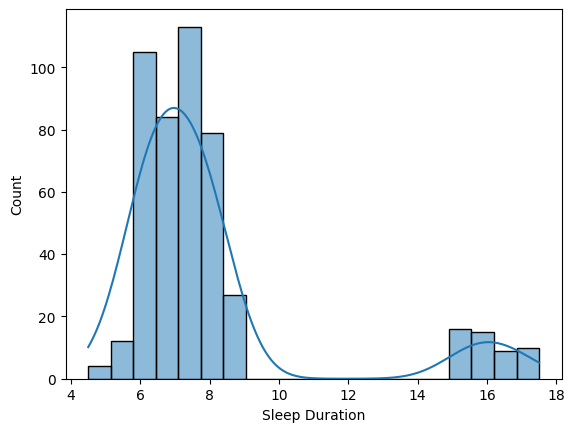

In [ ]:
# Sleep Duration
sns.histplot(data=df_combined, x='Sleep Duration', bins=20, kde=True)
plt.show()

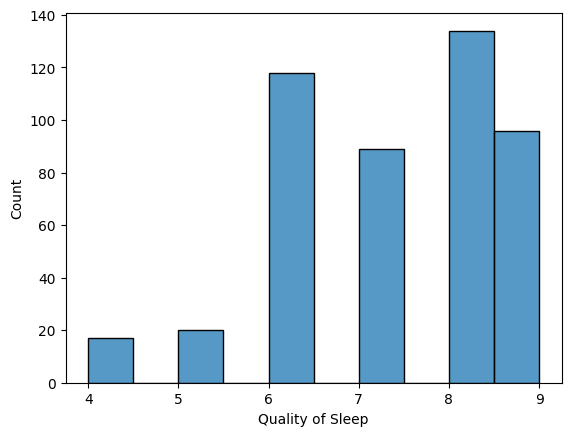

In [ ]:
# Quality of Sleep
sns.histplot(data=df_combined, x='Quality of Sleep')
plt.show()

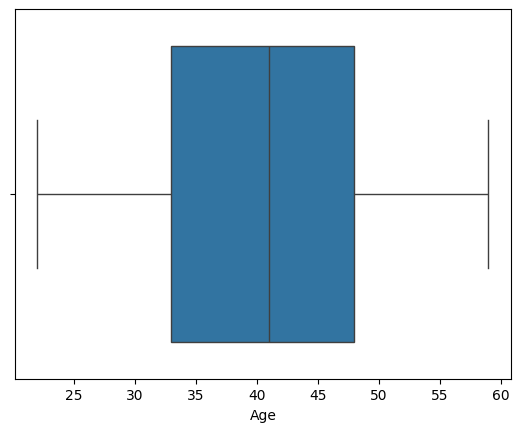

In [ ]:
# Age
sns.boxplot(data=df_combined, x='Age')
plt.show()

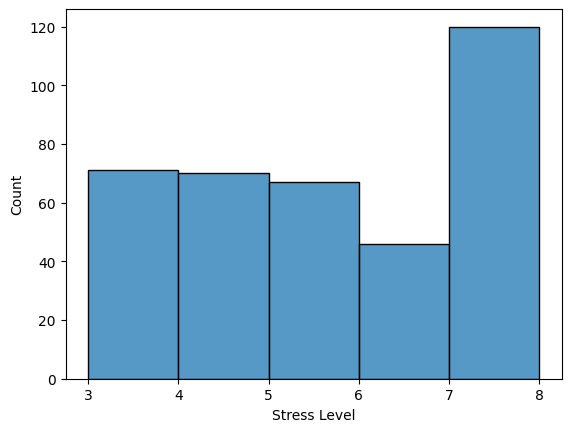

In [ ]:
# Stress Level
sns.histplot(data=df_combined, x='Stress Level', bins=5)
plt.show()

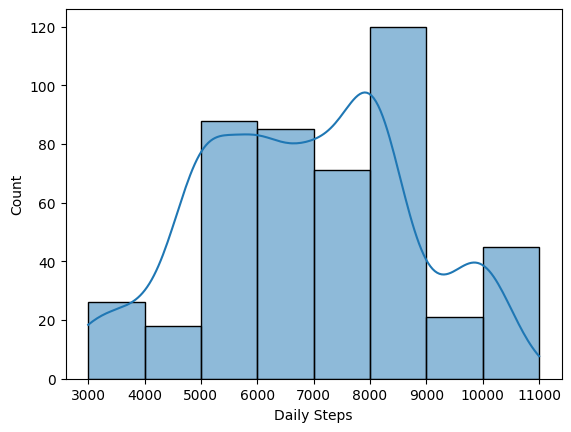

In [ ]:
# Daily Steps
sns.histplot(data=df_combined, x='Daily Steps', bins=8, kde=True)
plt.show()

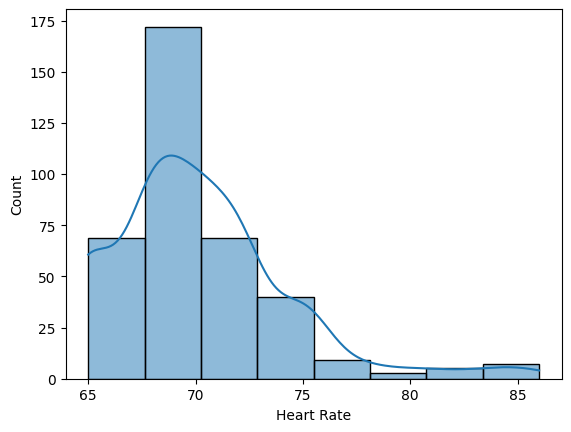

In [ ]:
# Heart Rate
sns.histplot(data=df_combined, x='Heart Rate', bins=8, kde=True)
plt.show()

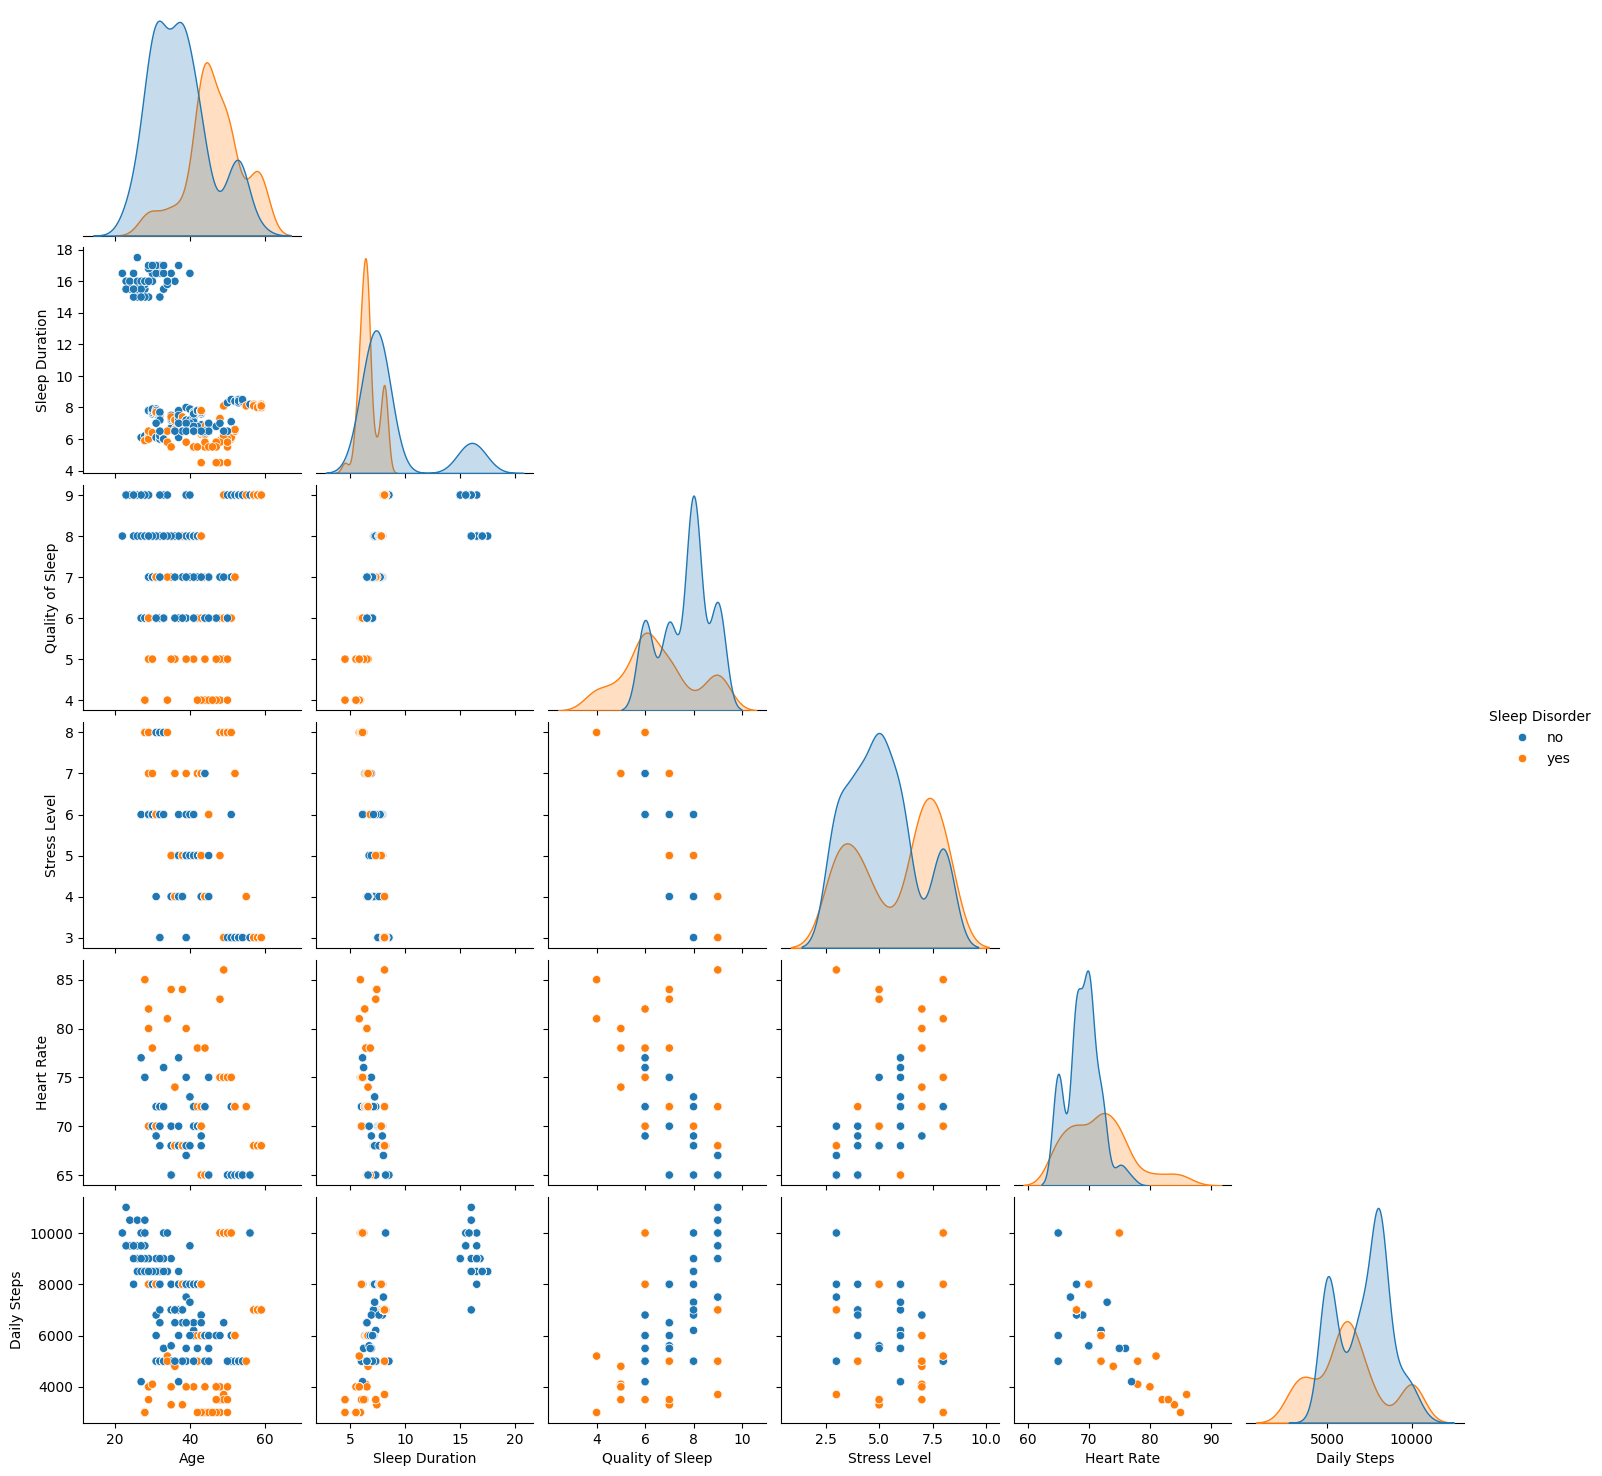

In [ ]:
# relationships with sleep disorder
numeric_cols = ['Age', 'Sleep Duration', 'Quality of Sleep',
                'Stress Level', 'Heart Rate', 'Daily Steps']

df_combined['Sleep Disorder'] = df_combined['Sleep Disorder'].astype('category')

sns.pairplot(data=df_combined, vars=numeric_cols, hue='Sleep Disorder', corner=True)
plt.show()

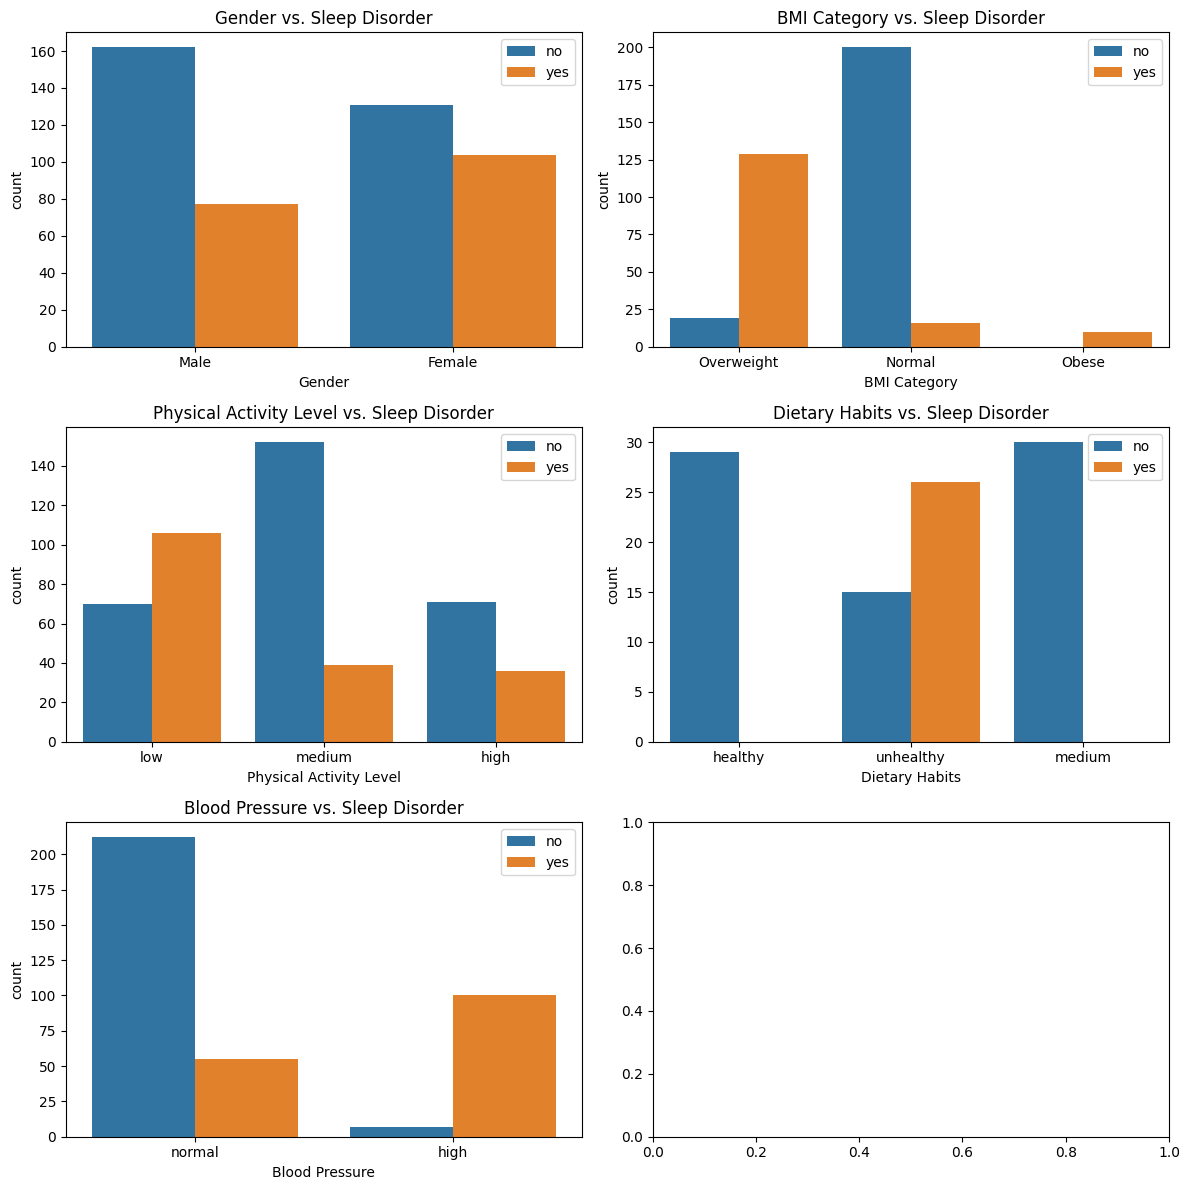

In [ ]:
categorical_vars = ['Gender', 'BMI Category', 'Physical Activity Level', 'Dietary Habits', 'Blood Pressure']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
axes = axes.flatten()

for i, cat in enumerate(categorical_vars):
    if i < len(axes):
        sns.countplot(data=df_combined, x=cat, hue='Sleep Disorder', ax=axes[i])
        axes[i].set_title(f'{cat} vs. Sleep Disorder')
        axes[i].legend(loc='upper right')

plt.tight_layout()
plt.show()

***EDA Findings***

In the exploratory data analysis, I began by examining how variables distributed across the dataset:
*   Sleep Duration ranged widely
*   Quality of sleep distribution skews right
*   Stress levels distribution skews right
*   Daily Steps has a fairly normal distribution
*   Heart rate distribution skews left
*   Generally equal gender distribution
*   About 1/3 of the dataset had instances of sleep disorders (38%)
*   Physical Activity Level distribution is fairly normal
*   Dietary Habits distribution is fairly normal
*   BMI Category skews towards normal
*   Over 2/3 of the data points have normal blood pressure

I then continued exploring potential relationships between different variables and the presence of sleep disorders I found that those with sleep disorders have:
*   Higher BMIs
*   Lower sleep duration
*   Higher blood pressure
*   Unhealthy dietary habits
*   Higher BMIs more likely to have sleep disorders
*   Lower activity levels
*   Less daily steps


Although these visual analyses do not imply direct causation, they provide insight and show patterns.

**Supervised Learning**

Why I Chose These Algorithms

Logistic Regression: Provides baseline method that highlights how each predictor affects the likelihood of having a sleep disorder.

K-Nearest Neighbors (KNN): avoids assumptions about the underlying data distribution, which can capture non-linear relationships

Random Forest: Reduces overfitting and improving predictive stability.

In [ ]:
# Logistic Regression

df_combined['Sleep Disorder'] = df_combined['Sleep Disorder'].map({'no': 0, 'yes': 1})
categorical_cols = ['Gender', 'Physical Activity Level', 'BMI Category', 'Blood Pressure', 'Dietary Habits']
numeric_cols = ['Age', 'Sleep Duration', 'Quality of Sleep', 'Stress Level', 'Heart Rate', 'Daily Steps']

df = pd.get_dummies(df_combined, columns=categorical_cols, drop_first=False)

# Impute missing values
numeric_cols = df.select_dtypes(include=np.number).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

X = df.drop('Sleep Disorder', axis=1)
y = df['Sleep Disorder']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

logreg = LogisticRegression(solver='liblinear', random_state=42)

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", accuracy)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Logistic Regression Confusion Matrix:\n", cm)

# Classification report
report = classification_report(y_test, y_pred)
print("Logistic Regression Classification Report:\n", report)

# Get Most Important Features
coefficients = logreg.coef_[0]
feature_names = X.columns

coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
})

coef_df = coef_df.sort_values(by='coefficient', ascending=False).reset_index(drop=True)

print("Features and Coefficients:")
print(coef_df)

Logistic Regression Accuracy: 0.9578947368421052
Logistic Regression Confusion Matrix:
 [[67  3]
 [ 1 24]]
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.97        70
           1       0.89      0.96      0.92        25

    accuracy                           0.96        95
   macro avg       0.94      0.96      0.95        95
weighted avg       0.96      0.96      0.96        95

Features and Coefficients:
                           feature  coefficient
0              Blood Pressure_high     1.065196
1          BMI Category_Overweight     0.976403
2      Physical Activity Level_low     0.449638
3               BMI Category_Obese     0.268962
4     Physical Activity Level_high     0.164781
5                              Age     0.114465
6                       Heart Rate     0.079186
7                    Gender_Female     0.056406
8                      Daily Steps     0.000109
9           Die

In [ ]:
# KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

# Evaluate the model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("KNN Accuracy:", accuracy_knn)

cm_knn = confusion_matrix(y_test, y_pred_knn)
print("KNN Confusion Matrix:\n", cm_knn)

report_knn = classification_report(y_test, y_pred_knn)
print("KNN Classification Report:\n", report_knn)

print(knn.get_params())


result = permutation_importance(knn, X_test, y_test, n_repeats=10, random_state=42)
importance_scores = result.importances_mean
feature_names = X.columns

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance_scores
})

feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
print(feature_importance_df)

KNN Accuracy: 0.9368421052631579
KNN Confusion Matrix:
 [[66  4]
 [ 2 23]]
KNN Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.94      0.96        70
           1       0.85      0.92      0.88        25

    accuracy                           0.94        95
   macro avg       0.91      0.93      0.92        95
weighted avg       0.94      0.94      0.94        95

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
                           feature  importance
5                      Daily Steps    0.253684
0                              Age    0.094737
6                    Gender_Female    0.006316
7                      Gender_Male    0.006316
4                       Heart Rate    0.004211
1                   Sleep Duration    0.004211
2                 Quality of Sleep    0.003158
13         BMI Category_Overweight    0.00000

In [ ]:
# Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

rf_classifier.fit(X_train, y_train)

y_pred_rf = rf_classifier.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)

cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Random Forest Confusion Matrix:\n", cm_rf)

report_rf = classification_report(y_test, y_pred_rf)
print("Random Forest Classification Report:\n", report_rf)

# Feature Importance
feature_importances = rf_classifier.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

Random Forest Accuracy: 0.968421052631579
Random Forest Confusion Matrix:
 [[67  3]
 [ 0 25]]
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        70
           1       0.89      1.00      0.94        25

    accuracy                           0.97        95
   macro avg       0.95      0.98      0.96        95
weighted avg       0.97      0.97      0.97        95

                           Feature  Importance
1                   Sleep Duration    0.153308
0                              Age    0.153123
13         BMI Category_Overweight    0.137583
14             Blood Pressure_high    0.111974
11             BMI Category_Normal    0.110241
2                 Quality of Sleep    0.074867
5                      Daily Steps    0.073293
9      Physical Activity Level_low    0.038830
3                     Stress Level    0.033101
4                       Heart Rate    0.032895
10  Physical Activity Le

**Findings**

Overall, each algorithm performed well for binary classification of the presence of sleep disorders. Logistic Regression and KNN both achieved accuracy scores around 93–94% on the test set. The confusion matrices showed that these models correctly classified the majority of cases, with only a small number of false positives and false negatives. Logistic Regression coefficients suggested that being overweight or obese, having high blood pressure, and engaging in lower physical activity corresponded to higher odds of having a sleep disorder.In KNN’s permutation importance results, daily steps and age are shown as influential features. Random Forest had the highest accuracy rate of 96.8% and provided an additional insight on feature importance showing sleep duration and age with the most feature importance.

**Conclusion**

The strong performance of all three algorithms shows that health and lifestyle data can help predict whether someone might have a sleep disorder. From the analysis, being overweight or obese, having higher blood pressure, and low physical activity all appear to be correlated to sleep disorders. This does not prove causation but these findings agree with common knowledge suggesting that an unhealthy lifestyle and higher stress can lead to poorer sleep. These results suggest that maintaining normal blood pressure, a healthy body weight, and regular physical activity are important steps one should take for good sleep health.

Logistic Regression is used to easily understand key factors when identifying people who might be at higher risk for sleep disorders. Meanwhile, KNN and Random Forest can handle more complex data and still offer strong predictions without always needing a simple explanation. Future research could involve gathering larger, more diverse datasets and looking at additional details like behavior, environment, and genes.